In [1]:
# We'll suppress warnings because both altair and sklearn are
# emitting lots of them, and they're annoying in a demo setting.

import warnings
warnings.filterwarnings("ignore")

import altair as alt
# Ask Altair to produce output that works on Jupyter Notebook
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [2]:
from fairness.algorithms.Algorithm import Algorithm
import pandas as pd

# Simple example that rebalances the training set wrt to the sensitive attribute
# to mitigate balancing problems, and uses any baseline SKLearn algorithm for prediction

# NB: This isn't a remotely good algorithm! 
#     But it's very simple to implement and gets the point across.

class SensitiveAttrRebalancing(Algorithm):
    def __init__(self, algorithm, baseline_name):
        # the only field you must initialize here is "name", which needs to be a
        # unique string that will be used to identify this algorithm in the
        # result data frames
        Algorithm.__init__(self)
        self.classifier = algorithm
        self.name = "SensitiveAttrRebalancing" + baseline_name
        
    def run(self, train_df, test_df, class_attr, positive_class_val, sensitive_attrs,
            single_sensitive, privileged_vals, params):
        # - train_df is a pandas dataframe with the training data
        # - test_df is a pandas dataframe with the testing data
        # - class_attr is the attribute to be predicted
        # - positive_class_value is the assumed "good" prediction, which might
        #   be necessary information for some methods
        # - sensitive_attrs is a list of the columns that are considered sensitive
        #   attributes for the sake of fairness
        # - single_sensitive is a boolean value reporting whether or not the dataset
        #   has more than one sensitive attribute
        # - privileged_vals is a list of values (one per sensitive attribute) of the
        #   values considered "privileged", which is necessary for one-sided definitions
        #   of discrimination
        # - params: a description of the hyperparameters being used for the current run
        
        # for sake of simplicity, we only support datasets with
        # a single sensitive attribute
        if not single_sensitive:
            raise Exception("Unsupported dataset")
        priv_val = privileged_vals[0]
        priv_attr = sensitive_attrs[0]
        total = len(train_df)
        
        train_priv = train_df[train_df[priv_attr] == priv_val]
        train_non_priv = train_df[train_df[priv_attr] != priv_val]
        
        train_priv_balance = train_priv.sample(n=int(total/2), replace=True)
        train_non_priv_balance = train_non_priv.sample(n=int(total/2), replace=True)
        
        train_df = pd.concat([train_priv_balance, train_non_priv_balance])
        

        # remove sensitive attributes from the training set
        train_df_nosensitive = train_df.drop(columns = sensitive_attrs)
        test_df_nosensitive = test_df.drop(columns = sensitive_attrs)

        # create and train the classifier
        classifier = self.classifier()
        y = train_df_nosensitive[class_attr]
        X = train_df_nosensitive.drop(columns = class_attr)
        classifier.fit(X, y)

        # get the predictions on the test set
        X_test = test_df_nosensitive.drop(class_attr, axis=1)
        predictions = classifier.predict(X_test)

        return predictions, []

    def get_supported_data_types(self):
        # There are currently four types of possible data types:
        #  - numerical
        #  - numerical-binsensitive
        #  - categorical
        #  - categorical-binsensitive
        #
        # a "numerical" datatype is one in which every column is numerical. If your algorithm
        # only supports numerical values (like an SVM or LR), then use "numerical-*" options
        #
        # a "-binsensitive" suffix refers to the fact that the sensitive attribute must be binary.
        # If your algorithm supports more than binary sensitive attributes, then you can
        # return "categorical" or "numerical" in this method.
        #
        # For the sake of simplicity, we use only the simplest option, "numerical-binsensitive".
        # In this case, the `fairness` package binarizes the sensitive attribute (but do note this
        # introduces potential problems with intersectionality, see Joy and Buolamwini's 2018 FAT*
        # paper for a clear example)
        return set(["numerical-binsensitive"])

In [3]:
import fairness
import fairness.benchmark
from sklearn.tree import DecisionTreeClassifier as SKLearn_DT

fairness.add_algorithm(SensitiveAttrRebalancing(SKLearn_DT, "DecisionTree"))

Available algorithms:
  SVM
  GaussianNB
  LR
  DecisionTree
  Kamishima
  Calders
  ZafarBaseline
  ZafarFairness
  ZafarAccuracy
  Kamishima-accuracy
  Kamishima-DIavgall
  Feldman-SVM
  Feldman-GaussianNB
  Feldman-LR
  Feldman-DecisionTree
  Feldman-SVM-DIavgall
  Feldman-SVM-accuracy
  Feldman-GaussianNB-DIavgall
  Feldman-GaussianNB-accuracy


In [4]:
fairness.benchmark.run(algorithm=["SensitiveAttrRebalancingDecisionTree"], dataset=["ricci"])

Datasets: '['ricci']'

Evaluating dataset:ricci
Sensitive attribute:Race
    Algorithm: SensitiveAttrRebalancingDecisionTree
       supported types: {'numerical-binsensitive'}
Results written to:
    /home/cscheid/.fairness/results/ricci_Race_numerical-binsensitive.csv


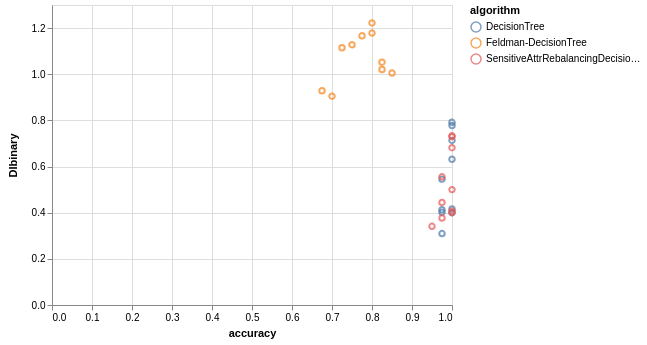

In [9]:
ricci_Race = fairness.get_dataset_by_name("ricci").get_results_data_frame("Race", "numerical-binsensitive")
ricci_Race = ricci_Race[ricci_Race.algorithm.str.contains("DecisionTree")]
alt.Chart(ricci_Race).mark_point().encode(
    x='accuracy',
    y='DIbinary',
    color='algorithm'
)